<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet("full_data.parquet")

In [3]:
df.head()

,event_id,session_id,transaction_date,event_type_id,product_id,title_product_id,country_code_id,ip_address,auth_session_id
0,0,3507032552,2020-08-20,4,63795519,63077424,162,238.108.111.146,2668673246
1,1,3506994387,2020-08-20,5,193402914,63110659,148,32.129.93.188,2668641289
2,2,3507038875,2020-08-20,5,202835637,63108769,517,222.60.132.210,2668676616
3,3,3507038876,2020-08-20,7,63109557,63109558,351,22.28.25.247,2668676617
4,4,3507036177,2020-08-20,4,69817018,63129191,162,138.169.123.254,2668677577


In [4]:
df.shape

(6044797, 9)

In [5]:
df.info(null_counts=True)

C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6044797 entries, 0 to 6044796
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   event_id          6044797 non-null  int64         
 1   session_id        6044797 non-null  object        
 2   transaction_date  6044797 non-null  datetime64[ns]
 3   event_type_id     6043230 non-null  object        
 4   product_id        6044797 non-null  int64         
 5   title_product_id  6044797 non-null  int64         
 6   country_code_id   6044462 non-null  object        
 7   ip_address        6044797 non-null  object        
 8   auth_session_id   5958585 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 415.1+ MB


In [6]:
df.transaction_date.value_counts()

2020-08-20 08:52:06    262
2020-08-20 07:28:35    218
2020-08-20 08:07:09    218
2020-08-20 08:11:40    202
2020-08-20 19:30:27    198
                      ... 
2020-08-20 04:22:42     14
2020-08-20 04:35:10     14
2020-08-20 04:16:40     13
2020-08-20 09:56:39     12
2020-08-20 05:17:03     12
Name: transaction_date, Length: 86400, dtype: int64

In [7]:
df['auth_session_id'].isnull().sum()

86212

In [8]:
# df['day'] = df['transaction_date'].apply(lambda x: x.day)
df['hour'] = df['transaction_date'].apply(lambda x: x.hour)
df['minute'] = df['transaction_date'].apply(lambda x: x.minute)
df['second'] = df['transaction_date'].apply(lambda x: x.second)

In [9]:
for col in df:
    print(col, df[col].nunique())

event_id 6044797
session_id 3586748
transaction_date 86400
event_type_id 26
product_id 2008439
title_product_id 21187
country_code_id 312
ip_address 1130066
auth_session_id 3213231
hour 24
minute 60
second 60


In [10]:
df.to_parquet('df_date.parquet')

In [ ]:
df_fe = df.drop(columns=['event_id', 'transaction_date'])

In [44]:
sid = '3509848836'

<AxesSubplot:xlabel='hour,minute'>

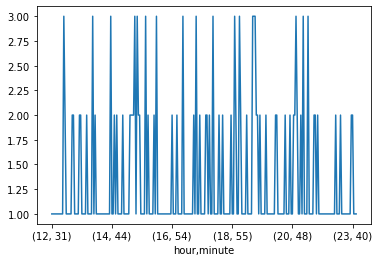

In [45]:
df[df["session_id"]==sid].groupby(['hour', 'minute'])['minute'].count().plot()

In [46]:
x = df[df["session_id"]==sid].groupby(['hour', 'minute'])['minute'].count()
x

hour  minute
12    31        1
      34        1
      35        1
      36        1
      38        1
               ..
23    35        2
      40        2
      47        1
      56        1
      58        1
Name: minute, Length: 254, dtype: int64

In [47]:
x = x.reset_index(name="count")
x

,hour,minute,count
0,12,31,1
1,12,34,1
2,12,35,1
3,12,36,1
4,12,38,1
...,...,...,...
249,23,35,2
250,23,40,2
251,23,47,1
252,23,56,1


In [48]:
from statsmodels.tsa.stattools import adfuller
print("Observations of Dickey-fuller test")
dftest = adfuller(x['count'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                -1.472656e+01
p-value                        2.700391e-27
#lags used                     0.000000e+00
number of observations used    2.530000e+02
critical value (1%)           -3.456464e+00
critical value (5%)           -2.873033e+00
critical value (10%)          -2.572895e+00
dtype: float64


In [49]:
dfoutput.loc['p-value']

2.700391478165577e-27

In [52]:
df['session_id'].unique()

array(['3507032552', '3506994387', '3507038875', ..., '3512455623',
       '3512460245', '3512465686'], dtype=object)

In [ ]:
ses_list = []
output = []
for sid in df['session_id'].unique():
    ses_list.append(sid)
    try:
        x = df[df["session_id"]==sid].groupby(['hour', 'minute'])['minute'].count()
        x = x.reset_index(name="count")

        dftest = adfuller(x['count'],autolag='AIC')
        dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
        for key,value in dftest[4].items():
            dfoutput['critical value (%s)'%key]= value
        p_val = dfoutput.loc['p-value']
        if p_val <= 0.01:
            output.append(1)
        else:
            output.append(0)
    except:
        output.append(None)

C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountere

C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountere

C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountere

C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountere

C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountere

C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountere

C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountere

C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountere

C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Vipooshan\anaconda3\envs\tf\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountere